In [35]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
import scipy.stats as sc
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import time

In [3]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [4]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

In [5]:
amip_ds = xr.open_dataset('../amip_aht.nc')
hist_ds = xr.open_dataset('../hist_aht.nc')
reanalysis_ds = xr.open_dataset('../reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

In [6]:
amip_std_error = xr.open_dataset('../amip_ds_trend_std_error.nc')
hist_std_error = xr.open_dataset('../hist_ds_trend_std_error.nc')
reanalysis_std_error = xr.open_dataset('../reanalysis_ds_trend_std_error.nc')
cesm_std_error = xr.open_dataset('../cesm2_le_ds_trend_std_error.nc')
cesm_goga_std_error = xr.open_dataset('../cesm2_amip_le_ds_trend_std_error.nc')
cesm_toga_std_error = xr.open_dataset('../cesm2_toga_amip_le_ds_trend_std_error.nc')

In [7]:
amip_Neff = xr.open_dataset('../amip_ds_trend_Neff.nc')
hist_Neff = xr.open_dataset('../hist_ds_trend_Neff.nc')
reanalysis_Neff = xr.open_dataset('../reanalysis_ds_trend_Neff.nc')
cesm_Neff = xr.open_dataset('../cesm2_le_ds_trend_Neff.nc')
cesm_goga_Neff = xr.open_dataset('../cesm2_amip_le_ds_trend_Neff.nc')
cesm_toga_Neff = xr.open_dataset('../cesm2_toga_amip_le_ds_trend_Neff.nc')

In [6]:
#All CESM runs are offset by one month - need to fix this, also have the spike every 10 year issue with this data

cesm2_time = pd.date_range("1950-01-01","2014-12-31",freq='1M')
cesm2_le_ds_full = xr.open_dataset('../../CESM_aht/CESM2_LENS2_aht_ds.nc')
cesm2_le_ds_full['time'] = cesm2_time
cesm2_le_ds = cesm2_le_ds_full.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_amip_time = pd.date_range("1949-12-31","2014-11-30",freq='1M')

cesm2_amip_le_ds = xr.open_dataset('../../CESM_aht/CESM2_GOGA_AMIP_aht_ds.nc')
cesm2_amip_le_ds['time'] = cesm2_amip_time
cesm2_amip_le_ds = cesm2_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_toga_amip_le_ds = xr.open_dataset('../../CESM_aht/CESM2_TOGA_AMIP_aht_ds.nc')
cesm2_toga_amip_le_ds['time'] = cesm2_amip_time
cesm2_toga_amip_le_ds = cesm2_toga_amip_le_ds.sel(time=slice('1980-01-01','2014-12-31'))

cesm2_le_trends = cesm2_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_amip_le_trends = cesm2_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
cesm2_toga_amip_le_trends = cesm2_toga_amip_le_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

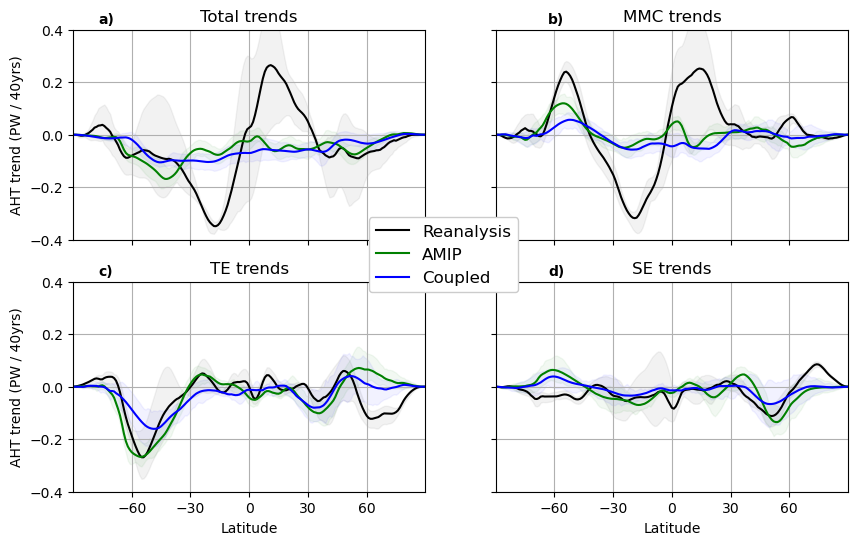

In [76]:
#fig, axs = plt.subplots(3, 2,  figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

#fig, axes = plt.subplot_mosaic("AA;BC;DE")
#x = [['A panel', 'A panel', 'edge'],
     #['C panel', '.',       'edge']]

panel_order = [['A', 'B'], ['C', 'D']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70
aht_conv = 40 / 1e15

ylims = [-0.4, 0.4]
xlims = [-90, 90]

which_quantiles = [0.25, 0.75]

amip_total_aht_std_err = aht_conv * np.sqrt((amip_std_error.total_aht ** 2 / amip_Neff.total_aht).sum('model'))
hist_total_aht_std_err = aht_conv * np.sqrt((hist_std_error.total_aht ** 2 / hist_Neff.total_aht).sum('model'))
reanalysis_total_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.total_aht ** 2 / reanalysis_Neff.total_aht).sum('model'))

amip_total_aht = aht_conv * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model')
amip_total_aht_quantiles = aht_conv * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
hist_total_aht = aht_conv * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_total_aht_quantiles = aht_conv * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
reanalysis_total_aht = aht_conv * reanalysis_trends.total_aht_polyfit_coefficients.sel(degree=1)

axs['A'].plot(reanalysis_trends.latitude, reanalysis_total_aht.mean('model'), color=reanalysis_color, label='Reanalysis')
axs['A'].fill_between(reanalysis_trends.latitude,  reanalysis_total_aht.min('model'),
                      reanalysis_total_aht.max('model'), color=reanalysis_color, alpha=0.05)
axs['A'].plot(amip_trends.latitude, amip_total_aht, color=amip_color, label='AMIP')
axs['A'].fill_between(amip_trends.latitude,  amip_total_aht_quantiles.isel(quantile=0),
                      amip_total_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.05)
axs['A'].plot(hist_trends.latitude, hist_total_aht, color=hist_color, label='Coupled')
axs['A'].fill_between(hist_trends.latitude,  hist_total_aht_quantiles.isel(quantile=0),
                      hist_total_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.05)

axs['A'].set_ylim(ylims)
axs['A'].set_xlim(xlims)
axs['A'].set_xticks([-60, -30, 0, 30, 60])
axs['A'].set_xticklabels('')
axs['A'].grid()
#axs['A'].axvline(vline1)
#axs['A'].axvline(vline2)
axs['A'].set_ylabel('AHT trend (PW / 40yrs)')
axs['A'].set_title('Total trends')

amip_mmc_aht_std_err = aht_conv * np.sqrt((amip_std_error.mmc_aht ** 2 / amip_Neff.mmc_aht).sum('model'))
hist_mmc_aht_std_err = aht_conv * np.sqrt((hist_std_error.mmc_aht ** 2 / hist_Neff.mmc_aht).sum('model'))
reanalysis_mmc_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.mmc_aht ** 2 / reanalysis_Neff.mmc_aht).sum('model'))

amip_mmc_aht = aht_conv * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model')
amip_mmc_aht_quantiles = aht_conv * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
hist_mmc_aht = aht_conv * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_mmc_aht_quantiles = aht_conv * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
reanalysis_mmc_aht = aht_conv * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1)

axs['B'].plot(reanalysis_trends.latitude, reanalysis_mmc_aht.mean('model'), color=reanalysis_color, label='Reanalysis')
axs['B'].fill_between(reanalysis_trends.latitude,  reanalysis_mmc_aht.min('model'),
                      reanalysis_mmc_aht.max('model'), color=reanalysis_color, alpha=0.05)
axs['B'].plot(amip_trends.latitude, amip_mmc_aht, color=amip_color, label='AMIP')
axs['B'].fill_between(amip_trends.latitude,  amip_mmc_aht_quantiles.isel(quantile=0),
                      amip_mmc_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.05)
axs['B'].plot(hist_trends.latitude, hist_mmc_aht, color=hist_color, label='Coupled')
axs['B'].fill_between(hist_trends.latitude,  hist_mmc_aht_quantiles.isel(quantile=0),
                      hist_mmc_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.05)

axs['B'].set_ylim(ylims)
axs['B'].set_xlim(xlims)
axs['B'].set_xticks([-60, -30, 0, 30, 60])
axs['B'].set_xticklabels('')
axs['B'].set_yticklabels('')
axs['B'].grid()
#axs['B'].axvline(vline1)
#axs['B'].axvline(vline2)
axs['B'].set_title('MMC trends')

amip_te_aht_std_err = aht_conv * np.sqrt((amip_std_error.te_aht ** 2 / amip_Neff.te_aht).sum('model'))
hist_te_aht_std_err = aht_conv * np.sqrt((hist_std_error.te_aht ** 2 / hist_Neff.te_aht).sum('model'))
reanalysis_te_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.te_aht ** 2 / reanalysis_Neff.te_aht).sum('model'))

amip_te_aht = aht_conv * amip_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model')
amip_te_aht_quantiles = aht_conv * amip_trends.te_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
hist_te_aht = aht_conv * hist_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_te_aht_quantiles = aht_conv * hist_trends.te_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
reanalysis_te_aht = aht_conv * reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1)

axs['C'].plot(reanalysis_trends.latitude, reanalysis_te_aht.mean('model'), color=reanalysis_color, label='Reanalysis')
axs['C'].fill_between(reanalysis_trends.latitude,  reanalysis_te_aht.min('model'),
                      reanalysis_te_aht.max('model'), color=reanalysis_color, alpha=0.05)
axs['C'].plot(amip_trends.latitude, amip_te_aht, color=amip_color, label='AMIP')
axs['C'].fill_between(amip_trends.latitude,  amip_te_aht_quantiles.isel(quantile=0),
                      amip_te_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.05)
axs['C'].plot(hist_trends.latitude, hist_te_aht, color=hist_color, label='Coupled')
axs['C'].fill_between(hist_trends.latitude,  hist_te_aht_quantiles.isel(quantile=0),
                      hist_te_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.05)

axs['C'].set_ylim(ylims)
axs['C'].set_xlim(xlims)
axs['C'].set_xticks([-60, -30, 0, 30, 60])
axs['C'].grid()
#axs['C'].axvline(vline1)
#axs['C'].axvline(vline2)
axs['C'].set_title('TE trends')
axs['C'].set_xlabel('Latitude')
axs['C'].set_ylabel('AHT trend (PW / 40yrs)')

amip_se_aht_std_err = aht_conv * np.sqrt((amip_std_error.se_aht ** 2 / amip_Neff.se_aht).sum('model'))
hist_se_aht_std_err = aht_conv * np.sqrt((hist_std_error.se_aht ** 2 / hist_Neff.se_aht).sum('model'))
reanalysis_se_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.se_aht ** 2 / reanalysis_Neff.se_aht).sum('model'))

amip_se_aht = aht_conv * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
amip_se_aht_quantiles = aht_conv * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
hist_se_aht = aht_conv * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_se_aht_quantiles = aht_conv * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')
reanalysis_se_aht = aht_conv * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1)

axs['D'].plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model'), color=reanalysis_color, label='Reanalysis')
axs['D'].fill_between(reanalysis_trends.latitude,  reanalysis_se_aht.min('model'),
                      reanalysis_se_aht.max('model'), color=reanalysis_color, alpha=0.05)
axs['D'].plot(amip_trends.latitude, amip_se_aht, color=amip_color, label='AMIP')
axs['D'].fill_between(amip_trends.latitude,  amip_se_aht_quantiles.isel(quantile=0),
                      amip_se_aht_quantiles.isel(quantile=1), color=amip_color, alpha=0.05)
axs['D'].plot(hist_trends.latitude, hist_se_aht, color=hist_color, label='Coupled')
axs['D'].fill_between(hist_trends.latitude,  hist_se_aht_quantiles.isel(quantile=0),
                      hist_se_aht_quantiles.isel(quantile=1), color=hist_color, alpha=0.05)

axs['D'].set_ylim(ylims)
axs['D'].set_xlim(xlims)
axs['D'].set_yticklabels('')
axs['D'].set_xticks([-60, -30, 0, 30, 60])
axs['D'].grid()
#axs['D'].axvline(vline1)
#axs['D'].axvline(vline2)
axs['D'].set_xlabel('Latitude')
axs['D'].set_title('SE trends')
axs['D'].set_zorder(1)
axs['D'].legend(loc=[-0.36, 0.95], fontsize=12, facecolor='white', framealpha=1)

#fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.text(0.15, 0.89, 'a)', fontweight='semibold')
fig.text(0.6, 0.89, 'b)', fontweight='semibold')
fig.text(0.15, 0.47, 'c)', fontweight='semibold')
fig.text(0.6, 0.47, 'd)', fontweight='semibold')

#plt.savefig('../figures/mean_aht_trends')
plt.show()

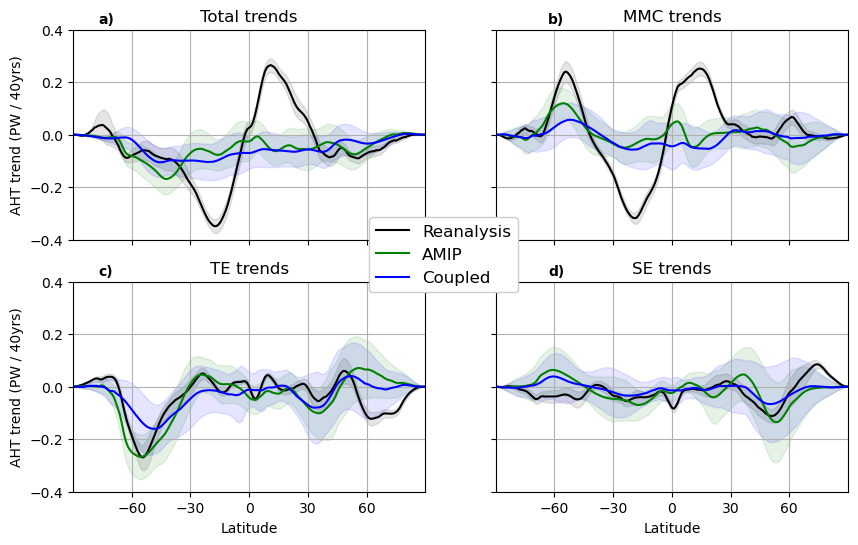

In [22]:
#fig, axs = plt.subplots(3, 2,  figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

#fig, axes = plt.subplot_mosaic("AA;BC;DE")
#x = [['A panel', 'A panel', 'edge'],
     #['C panel', '.',       'edge']]

panel_order = [['A', 'B'], ['C', 'D']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70
aht_conv = 40 / 1e15

ylims = [-0.4, 0.4]
xlims = [-90, 90]

amip_total_aht_std_err = aht_conv * np.sqrt((amip_std_error.total_aht ** 2 / amip_Neff.total_aht).sum('model'))
hist_total_aht_std_err = aht_conv * np.sqrt((hist_std_error.total_aht ** 2 / hist_Neff.total_aht).sum('model'))
reanalysis_total_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.total_aht ** 2 / reanalysis_Neff.total_aht).sum('model'))

amip_total_aht = aht_conv * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_total_aht = aht_conv * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model')
reanalysis_total_aht = aht_conv * reanalysis_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model')

axs['A'].plot(reanalysis_trends.latitude, reanalysis_total_aht, color=reanalysis_color)
axs['A'].fill_between(reanalysis_trends.latitude,  reanalysis_total_aht - reanalysis_total_aht_std_err,
                      reanalysis_total_aht + reanalysis_total_aht_std_err, color=reanalysis_color, alpha=0.1)
axs['A'].plot(amip_trends.latitude, amip_total_aht, color=amip_color)
axs['A'].fill_between(amip_trends.latitude,  amip_total_aht - amip_total_aht_std_err,
                      amip_total_aht + amip_total_aht_std_err, color=amip_color, alpha=0.1)
axs['A'].plot(hist_trends.latitude, hist_total_aht, color=hist_color)
axs['A'].fill_between(hist_trends.latitude,  hist_total_aht - hist_total_aht_std_err,
                      hist_total_aht + hist_total_aht_std_err, color=hist_color, alpha=0.1)
axs['A'].set_ylim(ylims)
axs['A'].set_xlim(xlims)
axs['A'].set_xticks([-60, -30, 0, 30, 60])
axs['A'].set_xticklabels('')
axs['A'].grid()
#axs['A'].axvline(vline1)
#axs['A'].axvline(vline2)
axs['A'].set_ylabel('AHT trend (PW / 40yrs)')
axs['A'].set_title('Total trends')

amip_mmc_aht_std_err = aht_conv * np.sqrt((amip_std_error.mmc_aht ** 2 / amip_Neff.mmc_aht).sum('model'))
hist_mmc_aht_std_err = aht_conv * np.sqrt((hist_std_error.mmc_aht ** 2 / hist_Neff.mmc_aht).sum('model'))
reanalysis_mmc_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.mmc_aht ** 2 / reanalysis_Neff.mmc_aht).sum('model'))

amip_mmc_aht = aht_conv * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_mmc_aht = aht_conv * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model')
reanalysis_mmc_aht = aht_conv * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model')

axs['B'].plot(reanalysis_trends.latitude, reanalysis_mmc_aht, color=reanalysis_color)
axs['B'].fill_between(reanalysis_trends.latitude,  reanalysis_mmc_aht - reanalysis_mmc_aht_std_err,
                      reanalysis_mmc_aht + reanalysis_mmc_aht_std_err, color=reanalysis_color, alpha=0.1)
axs['B'].plot(amip_trends.latitude, amip_mmc_aht, color=amip_color)
axs['B'].fill_between(amip_trends.latitude,  amip_mmc_aht - amip_mmc_aht_std_err,
                      amip_mmc_aht + amip_mmc_aht_std_err, color=amip_color, alpha=0.1)
axs['B'].plot(hist_trends.latitude, hist_mmc_aht, color=hist_color)
axs['B'].fill_between(hist_trends.latitude,  hist_mmc_aht - hist_mmc_aht_std_err,
                      hist_mmc_aht + hist_mmc_aht_std_err, color=hist_color, alpha=0.1)

axs['B'].set_ylim(ylims)
axs['B'].set_xlim(xlims)
axs['B'].set_xticks([-60, -30, 0, 30, 60])
axs['B'].set_xticklabels('')
axs['B'].set_yticklabels('')
axs['B'].grid()
#axs['B'].axvline(vline1)
#axs['B'].axvline(vline2)
axs['B'].set_title('MMC trends')

amip_te_aht_std_err = aht_conv * np.sqrt((amip_std_error.te_aht ** 2 / amip_Neff.te_aht).sum('model'))
hist_te_aht_std_err = aht_conv * np.sqrt((hist_std_error.te_aht ** 2 / hist_Neff.te_aht).sum('model'))
reanalysis_te_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.te_aht ** 2 / reanalysis_Neff.te_aht).sum('model'))

amip_te_aht = aht_conv * amip_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_te_aht = aht_conv * hist_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model')
reanalysis_te_aht = aht_conv * reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model')

axs['C'].plot(reanalysis_trends.latitude, reanalysis_te_aht, color=reanalysis_color)
axs['C'].fill_between(reanalysis_trends.latitude,  reanalysis_te_aht - reanalysis_te_aht_std_err,
                      reanalysis_te_aht + reanalysis_te_aht_std_err, color=reanalysis_color, alpha=0.1)
axs['C'].plot(amip_trends.latitude, amip_te_aht, color=amip_color)
axs['C'].fill_between(amip_trends.latitude,  amip_te_aht - amip_te_aht_std_err,
                      amip_te_aht + amip_te_aht_std_err, color=amip_color, alpha=0.1)
axs['C'].plot(hist_trends.latitude, hist_te_aht, color=hist_color)
axs['C'].fill_between(hist_trends.latitude,  hist_te_aht - hist_te_aht_std_err,
                      hist_te_aht + hist_te_aht_std_err, color=hist_color, alpha=0.1)

axs['C'].set_ylim(ylims)
axs['C'].set_xlim(xlims)
axs['C'].set_xticks([-60, -30, 0, 30, 60])
axs['C'].grid()
#axs['C'].axvline(vline1)
#axs['C'].axvline(vline2)
axs['C'].set_title('TE trends')
axs['C'].set_xlabel('Latitude')
axs['C'].set_ylabel('AHT trend (PW / 40yrs)')

amip_se_aht_std_err = aht_conv * np.sqrt((amip_std_error.se_aht ** 2 / amip_Neff.se_aht).sum('model'))
hist_se_aht_std_err = aht_conv * np.sqrt((hist_std_error.se_aht ** 2 / hist_Neff.se_aht).sum('model'))
reanalysis_se_aht_std_err = aht_conv * np.sqrt((reanalysis_std_error.se_aht ** 2 / reanalysis_Neff.se_aht).sum('model'))

amip_se_aht = aht_conv * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
hist_se_aht = aht_conv * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
reanalysis_se_aht = aht_conv * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')

axs['D'].plot(reanalysis_trends.latitude, reanalysis_se_aht, color=reanalysis_color, label='Reanalysis')
axs['D'].fill_between(reanalysis_trends.latitude,  reanalysis_se_aht - reanalysis_se_aht_std_err,
                      reanalysis_se_aht + reanalysis_se_aht_std_err, color=reanalysis_color, alpha=0.1)
axs['D'].plot(amip_trends.latitude, amip_se_aht, color=amip_color, label='AMIP')
axs['D'].fill_between(amip_trends.latitude,  amip_se_aht - amip_se_aht_std_err,
                      amip_se_aht + amip_se_aht_std_err, color=amip_color, alpha=0.1)
axs['D'].plot(hist_trends.latitude, hist_se_aht, color=hist_color, label='Coupled')
axs['D'].fill_between(hist_trends.latitude,  hist_se_aht - hist_se_aht_std_err,
                      hist_se_aht + hist_se_aht_std_err, color=hist_color, alpha=0.1)
axs['D'].set_ylim(ylims)
axs['D'].set_xlim(xlims)
axs['D'].set_yticklabels('')
axs['D'].set_xticks([-60, -30, 0, 30, 60])
axs['D'].grid()
#axs['D'].axvline(vline1)
#axs['D'].axvline(vline2)
axs['D'].set_xlabel('Latitude')
axs['D'].set_title('SE trends')
axs['D'].set_zorder(1)
axs['D'].legend(loc=[-0.36, 0.95], fontsize=12, facecolor='white', framealpha=1)

#fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.text(0.15, 0.89, 'a)', fontweight='semibold')
fig.text(0.6, 0.89, 'b)', fontweight='semibold')
fig.text(0.15, 0.47, 'c)', fontweight='semibold')
fig.text(0.6, 0.47, 'd)', fontweight='semibold')

#plt.savefig('../figures/mean_aht_trends')
plt.show()

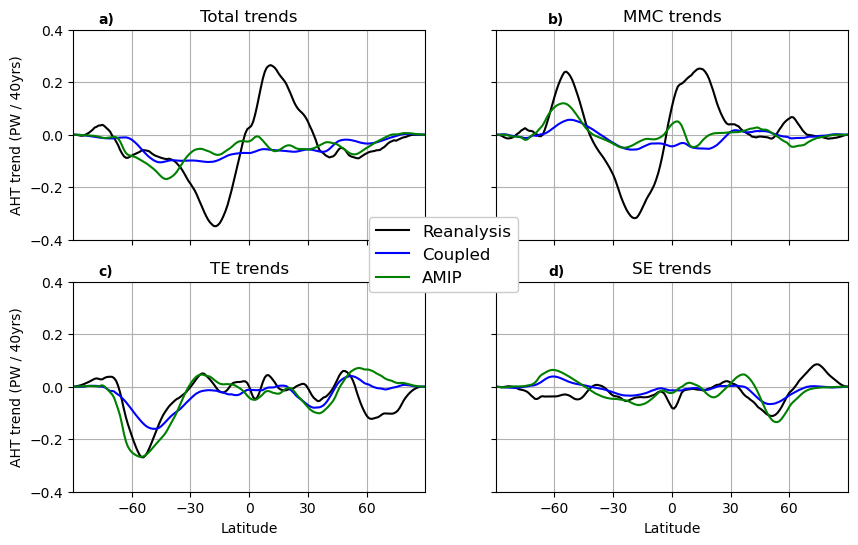

In [8]:
#fig, axs = plt.subplots(3, 2,  figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1, 1]})

#fig, axes = plt.subplot_mosaic("AA;BC;DE")
#x = [['A panel', 'A panel', 'edge'],
     #['C panel', '.',       'edge']]

panel_order = [['A', 'B'], ['C', 'D']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))
reanalysis_color = 'k'
hist_color = 'b'
amip_color = 'g'
cesm2_le_color = 'orange'
cesm2_amip_color = 'purple'
cesm2_toga_amip_color = 'red'
vline1 = 50
vline2 = 70

ylims = [-0.4, 0.4]
xlims = [-90, 90]

amip_total_aht_std_err = np.sqrt((amip_std_error.total_aht ** 2 / 35).sum('model'))

axs['A'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['A'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['A'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.total_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['A'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_le_color)
#axs['A'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['A'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.total_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['A'].set_ylim(ylims)
axs['A'].set_xlim(xlims)
axs['A'].set_xticks([-60, -30, 0, 30, 60])
axs['A'].set_xticklabels('')
axs['A'].grid()
#axs['A'].axvline(vline1)
#axs['A'].axvline(vline2)
axs['A'].set_ylabel('AHT trend (PW / 40yrs)')
axs['A'].set_title('Total trends')

axs['B'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['B'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['B'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['B'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.mmc_aht_dry_pot_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_le_color)
#axs['B'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_amip_color)
#axs['B'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.mmc_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=cesm2_toga_amip_color)
axs['B'].set_ylim(ylims)
axs['B'].set_xlim(xlims)
axs['B'].set_xticks([-60, -30, 0, 30, 60])
axs['B'].set_xticklabels('')
axs['B'].set_yticklabels('')
axs['B'].grid()
#axs['B'].axvline(vline1)
#axs['B'].axvline(vline2)
axs['B'].set_title('MMC trends')

axs['C'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color)
axs['C'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color)
axs['C'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.te_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color)
#axs['C'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.te_aht_dry_pot_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_le_color)
#axs['C'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color)
#axs['C'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.te_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color)
axs['C'].set_ylim(ylims)
axs['C'].set_xlim(xlims)
axs['C'].set_xticks([-60, -30, 0, 30, 60])
axs['C'].grid()
#axs['C'].axvline(vline1)
#axs['C'].axvline(vline2)
axs['C'].set_title('TE trends')
axs['C'].set_xlabel('Latitude')
axs['C'].set_ylabel('AHT trend (PW / 40yrs)')

axs['D'].plot(reanalysis_trends.latitude, 40 / 1e15 * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=reanalysis_color, label='Reanalysis')
axs['D'].plot(hist_trends.latitude, 40 / 1e15 * hist_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=hist_color, label='Coupled')
axs['D'].plot(amip_trends.latitude, 40 / 1e15 * amip_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model'), color=amip_color, label='AMIP')
#axs['D'].plot(cesm2_le_trends.latitude, 40 / 1e15 * cesm2_le_trends.se_aht_dry_pot_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_le_color, label='CESM2 LE')
#axs['D'].plot(cesm2_amip_le_trends.latitude, 40 / 1e15 * cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_amip_color, label='CESM AMIP')
#axs['D'].plot(cesm2_toga_amip_le_trends.latitude, 40 / 1e15 * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).median('model'), color=cesm2_toga_amip_color, label='CESM TOGA AMIP')
axs['D'].set_ylim(ylims)
axs['D'].set_xlim(xlims)
axs['D'].set_yticklabels('')
axs['D'].set_xticks([-60, -30, 0, 30, 60])
axs['D'].grid()
#axs['D'].axvline(vline1)
#axs['D'].axvline(vline2)
axs['D'].set_xlabel('Latitude')
axs['D'].set_title('SE trends')
axs['D'].set_zorder(1)
axs['D'].legend(loc=[-0.36, 0.95], fontsize=12, facecolor='white', framealpha=1)

#fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)

fig.text(0.15, 0.89, 'a)', fontweight='semibold')
fig.text(0.6, 0.89, 'b)', fontweight='semibold')
fig.text(0.15, 0.47, 'c)', fontweight='semibold')
fig.text(0.6, 0.47, 'd)', fontweight='semibold')

#plt.savefig('../figures/mean_aht_trends')
plt.show()

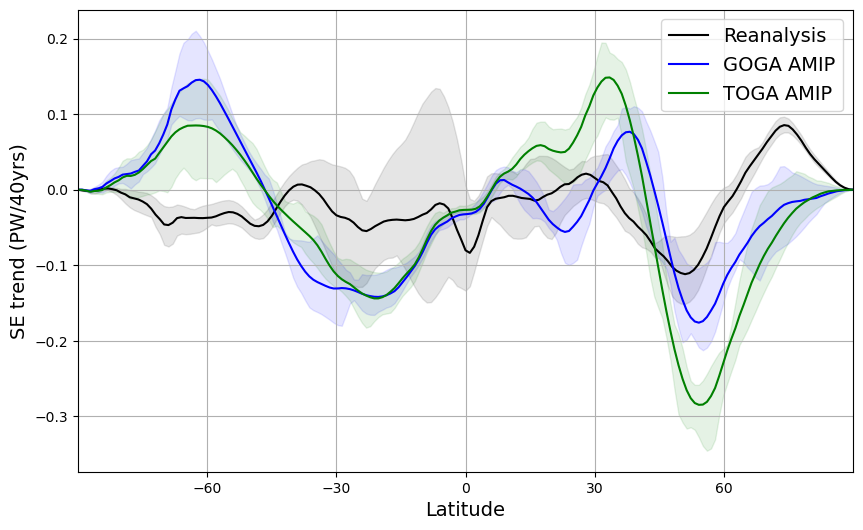

In [42]:
plt.figure(figsize=(10,6))
adjust = 40 / 1e15

cesm_goga_se_aht_std_err = adjust * np.sqrt((cesm_goga_std_error.se_aht ** 2 / cesm_goga_Neff.se_aht).sum('model'))
cesm_toga_se_aht_std_err = adjust * np.sqrt((cesm_toga_std_error.se_aht ** 2 / cesm_toga_Neff.se_aht).sum('model'))
reanalysis_se_aht_std_err = adjust * np.sqrt((reanalysis_std_error.se_aht ** 2 / reanalysis_Neff.se_aht).sum('model'))

cesm_goga_se_aht = aht_conv * cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
cesm_goga_se_aht_quantiles = aht_conv * cesm2_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')

cesm_toga_se_aht = aht_conv * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).mean('model')
cesm_toga_se_aht_quantiles = aht_conv * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.sel(degree=1).quantile(which_quantiles, dim='model')

reanalysis_se_aht = aht_conv * reanalysis_trends.se_aht_polyfit_coefficients.sel(degree=1)

plt.plot(reanalysis_trends.latitude, reanalysis_se_aht.mean('model'), color='k', label='Reanalysis')
plt.fill_between(reanalysis_trends.latitude,  reanalysis_se_aht.min('model'),
                      reanalysis_se_aht.max('model'), color='k', alpha=0.1)

plt.plot(cesm2_amip_le_trends.latitude, cesm_goga_se_aht, color='b', label='GOGA AMIP')
plt.fill_between(cesm2_amip_le_trends.latitude,  cesm_goga_se_aht_quantiles.isel(quantile=0),
                      cesm_goga_se_aht_quantiles.isel(quantile=1), color='b', alpha=0.1)

plt.plot(cesm2_amip_le_trends.latitude, cesm_toga_se_aht, color='g', label='TOGA AMIP')
plt.fill_between(cesm2_amip_le_trends.latitude,  cesm_toga_se_aht_quantiles.isel(quantile=0),
                      cesm_toga_se_aht_quantiles.isel(quantile=1), color='g', alpha=0.1)

plt.xticks([-60, -30, 0, 30, 60])

plt.xlim([-90, 90])
plt.grid()

plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SE trend (PW/40yrs)', fontsize=14)

plt.legend(loc=0, fontsize=14)

#plt.savefig('../figures/goga_toga_reanalysis_se_trends')
plt.show()

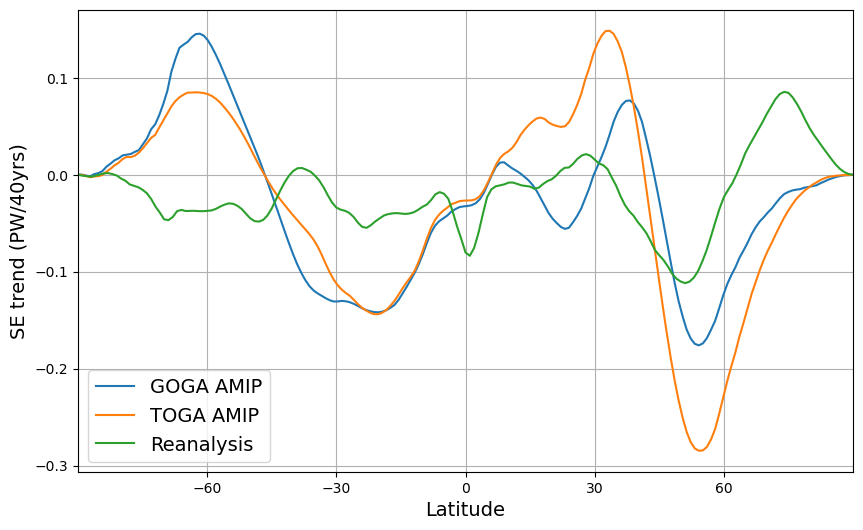

In [9]:
plt.figure(figsize=(10,6))
adjust = 40 / 1e15
plt.plot(cesm2_amip_le_trends.latitude, adjust * cesm2_amip_le_trends.se_aht_polyfit_coefficients.mean('model').sel(degree=1),
        label='GOGA AMIP')
plt.plot(cesm2_toga_amip_le_trends.latitude, adjust * cesm2_toga_amip_le_trends.se_aht_polyfit_coefficients.mean('model').sel(degree=1),
        label='TOGA AMIP')
plt.plot(reanalysis_trends.latitude, adjust * reanalysis_trends.se_aht_polyfit_coefficients.mean('model').sel(degree=1),
        label='Reanalysis')
          
         
plt.xticks([-60, -30, 0, 30, 60])

plt.xlim([-90, 90])
plt.grid()

plt.xlabel('Latitude', fontsize=14)
plt.ylabel('SE trend (PW/40yrs)', fontsize=14)

plt.legend(loc=0, fontsize=14)

#plt.savefig('../figures/goga_toga_reanalysis_se_trends')
plt.show()

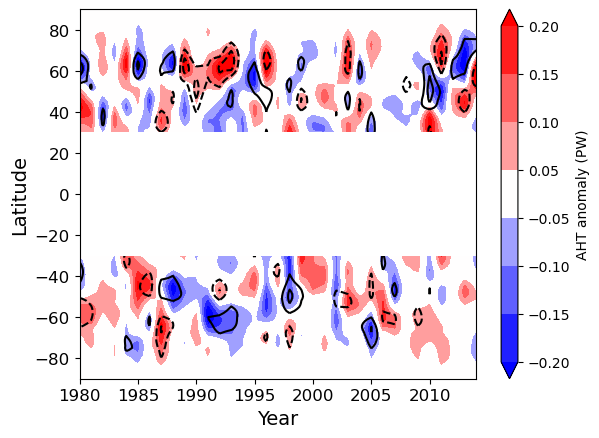

In [71]:
which_lat = -55

reanalysis_annual = reanalysis_ds.groupby('time.year').mean('time')
#reanalysis_annual_pfit = reanalysis_annual.polyfit(dim='year', deg=1)
#reanalysis_annual_fit = xr.polyval('year', reanalysis_annual_pfit.polyfit_coefficients)

#reanalysis_annual_anom = reanalysis_annual - reanalysis_annual.mean('year')

def detrend_dim_anom(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    detrended = da - fit
    detrended_anom = detrended - detrended.mean(dim)
    return detrended_anom

eddy_plot_val = detrend_dim_anom(reanalysis_annual.eddy_aht.mean('model'), 'year')
mmc_plot_val = detrend_dim_anom(reanalysis_annual.mmc_aht.mean('model'), 'year')

#plt.plot(range(1980, 2015), reanalysis_annual.mmc_aht.sel(latitude=which_lat).mean('model'))

#ax2 = plt.twinx()

#ax2.plot(range(1980, 2015), reanalysis_annual.te_aht.sel(latitude=which_lat).mean('model'),
        #color='r')

contf_levs = [-0.2, -0.15, -0.1, -0.05, 0.05, .1, 0.15,  .2]
cont_levs = [-0.2, -0.1, .1,  .2]

contf = plt.contourf(range(1980, 2015), lats, eddy_plot_val.T / 1e15,
            cmap='bwr', levels=contf_levs, extend='both')#np.linspace(-0.5, 0.5, 10))

#cont_levs = [-0.5, -0.4, -0.3, -0.2, -0.1, .1, .2, .3, .4, .5]

plt.contour(range(1980, 2015), lats, mmc_plot_val.T / 1e15,
            colors='k', levels=cont_levs)

plt.colorbar(contf, label='AHT anomaly (PW)')

rect = patches.Rectangle((1980, -30), 35, 60, linewidth=1, edgecolor='none', facecolor='white',
                        zorder=2)

# Add the patch to the Axes
plt.gca().add_patch(rect)


plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.xlim([1980, 2014])

plt.xlabel('Year', fontsize=14)
plt.ylabel('Latitude',  fontsize=14)
plt.xticks(size=12)
plt.yticks(size=12)

#plt.savefig('../figures/eddy_colors_mmc_contours_annual_anomalies')
plt.show()

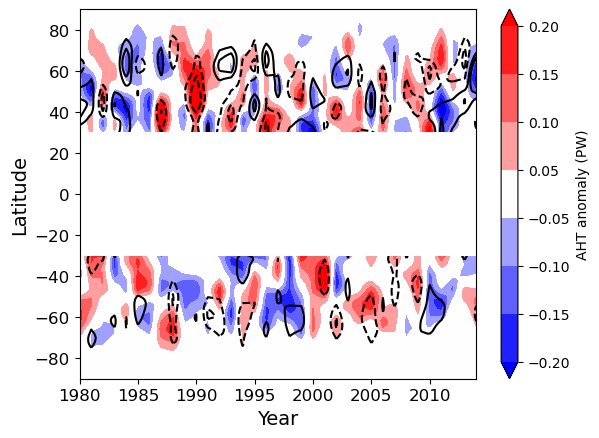

In [72]:
which_lat = -55

reanalysis_annual = reanalysis_ds.groupby('time.year').mean('time')
#reanalysis_annual_pfit = reanalysis_annual.polyfit(dim='year', deg=1)
#reanalysis_annual_fit = xr.polyval('year', reanalysis_annual_pfit.polyfit_coefficients)

#reanalysis_annual_anom = reanalysis_annual - reanalysis_annual.mean('year')

def detrend_dim_anom(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    detrended = da - fit
    detrended_anom = detrended - detrended.mean(dim)
    return detrended_anom

te_plot_val = detrend_dim_anom(reanalysis_annual.te_aht.mean('model'), 'year')
se_plot_val = detrend_dim_anom(reanalysis_annual.se_aht.mean('model'), 'year')

#plt.plot(range(1980, 2015), reanalysis_annual.mmc_aht.sel(latitude=which_lat).mean('model'))

#ax2 = plt.twinx()

#ax2.plot(range(1980, 2015), reanalysis_annual.te_aht.sel(latitude=which_lat).mean('model'),
        #color='r')

contf_levs = [-0.2, -0.15, -0.1, -0.05, 0.05, .1, 0.15,  .2]
cont_levs = [-0.2, -0.1, .1,  .2]

contf = plt.contourf(range(1980, 2015), lats, te_plot_val.T / 1e15,
            cmap='bwr', levels=contf_levs, extend='both')#np.linspace(-0.5, 0.5, 10))

#cont_levs = [-0.5, -0.4, -0.3, -0.2, -0.1, .1, .2, .3, .4, .5]

plt.contour(range(1980, 2015), lats, se_plot_val.T / 1e15,
            colors='k', levels=cont_levs)

plt.colorbar(contf, label='AHT anomaly (PW)')

rect = patches.Rectangle((1980, -30), 35, 60, linewidth=1, edgecolor='none', facecolor='white',
                        zorder=2)

# Add the patch to the Axes
plt.gca().add_patch(rect)


plt.xticks([1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015])
plt.xlim([1980, 2014])

plt.xlabel('Year', fontsize=14)
plt.ylabel('Latitude',  fontsize=14)
plt.xticks(size=12)
plt.yticks(size=12)

#plt.savefig('../figures/te_colors_se_contours_annual_anomalies')

plt.show()